In [169]:
### SPARK imports

from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType,BooleanType
from pyspark.sql import Window

from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler


In [2]:
### Regular python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import getpass
%matplotlib inline

In [3]:
#Set the paths here!

user = getpass.getuser()
if user == "sidsel":
    parquet = "/home/"+user+"/workspace/sparkdata/parquet/"
    regnskabsData = "alleregnskaber.parquet"
    cvrData = "virkdata.parquet"
    csvpath = "/home/"+user+'/workspace/sparkdata/csv'

elif user == "svanhmic":
    cvrParquetPath = "/home/"+user+"/workspace/data/DABAI/sparkdata/parquet/"
    regnskabParquetPath = "/home/"+user+"/workspace/data/DABAI/sparkdata/parquet/" 
    csvpath = "/home/"+user+'/workspace/data/DABAI/sparkdata/csv'
    picture_Path = "/home/"+user+"/workspace/results/pictures"

In [4]:
zeroYearWindow = Window.partitionBy("cvr")
laggValueWindow = Window.partitionBy("cvr").orderBy("End_Instant")

In [5]:
#import data and do transformations

iktBrancheDf = sqlContext.read.parquet(cvrParquetPath+"IktBrancher.parquet").cache()
notIktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktNotGazeller.parquet")
iktGazelleDf = sqlContext.read.parquet(cvrParquetPath+"IktGazeller.parquet")

largeGap = F.lag(F.col("Year"),1,0).over(laggValueWindow)-F.col("Year")

notReallyGazelleDf = (iktGazelleDf
                .withColumn("Year",F.year(F.col("End_Instant")))
                .withColumn("gap",largeGap)
                .withColumn("isGap",F.when((largeGap >= -1) | (largeGap <= -2000),True).otherwise(False))
                .filter(F.col("isGap") == False)
                .select("cvr")
                .distinct()
               )

iktGazelleDf = (iktGazelleDf
                .select("cvr")
                .distinct()
                .subtract(notReallyGazelleDf)
                .join(iktGazelleDf,("cvr"),"inner")
                .cache()
               )


notIktGazelleDf = (notIktGazelleDf
                   .drop("rank")
                   .withColumn("GrossResult",F.col("GrossResult").cast("double"))
                   .withColumn("Revenue",F.col("Revenue").cast("double"))
                   .withColumn("LaggedGrossResult",F.col("GrossResult")-F.lag(F.col("GrossResult")).over(laggValueWindow))
                   .filter(F.col("LaggedGrossResult") >= 0.0)
                   .withColumn("FirstRevenue",F.when(F.col("Revenue") >= 1000000,True).otherwise(False))
                   .withColumn("FirstGrossResult",F.when(F.col("GrossResult") >= 500000,True).otherwise(False))
                   .filter((F.col("FirstGrossResult")==True) | (F.col("Revenue")==True))
                   .withColumn("Year", F.rank().over(laggValueWindow).cast("double")-1)
                   .withColumn("maxRank",F.max("Year").over(zeroYearWindow).cast("double"))
                   .filter(F.col("maxRank") >= 3) # re want to predict for at least four values
                   .drop("maxRank")
                   #.filter(F.col("cvr") == 10008123)
                   .cache()
               )

print("Number of Non-Gazell points: "+str(notIktGazelleDf.count()))
print("Number of Non-Gazell cvr-numbers: "+str(notIktGazelleDf.select("cvr").distinct().count()))
print("Number of Gazell points: "+str(iktGazelleDf.count()))
print("Number of Gazells cvr-numbers: "+str(iktGazelleDf.select("cvr").distinct().count()))


#How  many are there in each IKT-subbranche for cvrs with more than a mio or half mio? 
(notIktGazelleDf
 .select("cvr","branchekode","Branchenavn")
 .distinct()
 .groupBy("Branchenavn","branchekode")
 .count()
 .show(truncate=False))

Number of Non-Gazell points: 672
Number of Non-Gazell cvr-numbers: 110
Number of Gazell points: 364
Number of Gazells cvr-numbers: 95
+-----------------------------------------------------+-----------+-----+
|Branchenavn                                          |branchekode|count|
+-----------------------------------------------------+-----------+-----+
|Engroshandel med elektronisk udstyr                  |465210     |6    |
|Computer facility management                         |620300     |2    |
|Fastnetbaseret telekommunikation                     |611000     |11   |
|Fremstilling af elektronik til husholdninger         |264000     |1    |
|Engroshandel med computere, ydre enheder og software |465100     |21   |
|Databehandling, webhosting og lignende serviceydelser|631100     |5    |
|Reparation af kommunikationsudstyr                   |951200     |1    |
|Fremstilling af kommunikationsudstyr                 |263000     |3    |
|Anden udgivelse af software                        

In [55]:
totalIktUnionDf.show()

+--------+------+------------------+------------------+------------------+--------------------+---------------------+---------+
|     cvr|  year|       GrossResult|   GrossProfitLoss|           Revenue|        branchetekst|Standardgruppering_19|isGazelle|
+--------+------+------------------+------------------+------------------+--------------------+---------------------+---------+
|14674748|2016.0|               0.0|13.694809644439719|               0.0|Computerprogramme...| Information og ko...|    Other|
|14674748|2015.0|               0.0|13.699439555941606|               0.0|Computerprogramme...| Information og ko...|    Other|
|14674748|2014.0|               0.0|13.859784826523109|               0.0|Computerprogramme...| Information og ko...|    Other|
|14674748|2013.0|               0.0|13.860630184420888|               0.0|Computerprogramme...| Information og ko...|    Other|
|16724041|2016.0|               0.0|16.381522197158578|               0.0|Engroshandel undt...| Handel o

In [6]:
commomCols = ["cvr",F.year("End_Instant").cast("double").alias("year")
              ,F.log1p("GrossResult").alias("GrossResult")
              ,F.log1p("GrossProfitLoss").alias("GrossProfitLoss")
              ,F.log1p("Revenue").alias("Revenue")
              ,"branchetekst","Standardgruppering_19"]

notIktGazelle2Df = (notIktGazelleDf
                    .select(commomCols)
                    .withColumn("isGazelle",F.lit("candidate Gazelle"))
                   )
#notIktGazelle2Df.printSchema()
iktGazelleCandidatesDf = (iktBrancheDf
                 .join(iktGazelleDf.select("cvr").distinct(),("cvr"),"inner")
                 .select(commomCols)
                 .withColumn("isGazelle",F.lit("Gazelle"))
                )
iktGazelleCandidatesDf.printSchema()

unionGazellsDf = notIktGazelle2Df.unionAll(iktGazelleCandidatesDf)


iktNonCandidatesDf = (iktBrancheDf
                      .select("cvr")
                      .distinct()
                      .subtract(unionGazellsDf.select("cvr").distinct())
                      .join(iktBrancheDf,("cvr"),"inner")
                      .select(commomCols)
                      .withColumn("isGazelle",F.lit("Other"))
                     )
iktNonCandidatesDf.count()

totalIktUnionDf = iktNonCandidatesDf.unionAll(unionGazellsDf)

root
 |-- cvr: integer (nullable = true)
 |-- year: double (nullable = true)
 |-- GrossResult: double (nullable = true)
 |-- GrossProfitLoss: double (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- branchetekst: string (nullable = true)
 |-- Standardgruppering_19: string (nullable = true)
 |-- isGazelle: string (nullable = false)



In [7]:
iktGazelleDf.describe().show()

+-------+--------------------+-------------------+------------------+--------------------+------------------+--------------------+
|summary|                 cvr|              Value|              rank|         LaggedValue|           maxRank|    factorSinceStart|
+-------+--------------------+-------------------+------------------+--------------------+------------------+--------------------+
|  count|                 364|                364|               364|                 364|               364|                 364|
|   mean|2.9822690552197803E7|1.209471254120879E7|2.3434065934065935|   3379113.526098901|3.6868131868131866|   1.076209695010702|
| stddev|   5277142.113755334|4.442312575115428E7|1.1184332999100088|1.0714723538581628E7|0.6127585265311679|  1.5631964511280796|
|    min|            10023920|           502087.0|                 1|                 0.0|                 3|-0.22568093385214008|
|    max|            35864962|        5.5791501E8|                 6|        1.3728

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


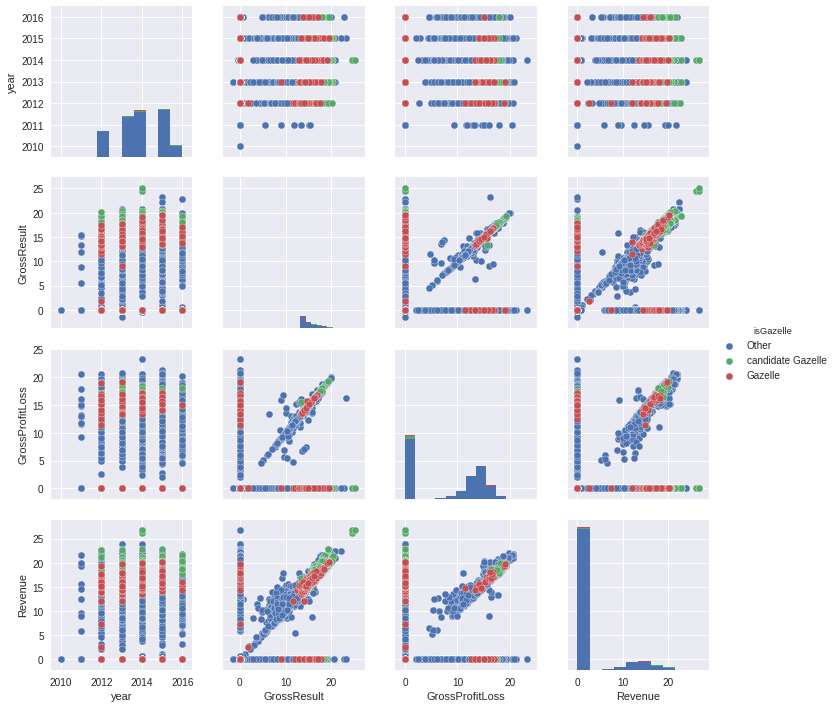

In [8]:
### All years combined
axes = sb.pairplot(totalIktUnionDf.drop("cvr").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.savefig(picture_Path+"/EntireIktBranche.png")
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


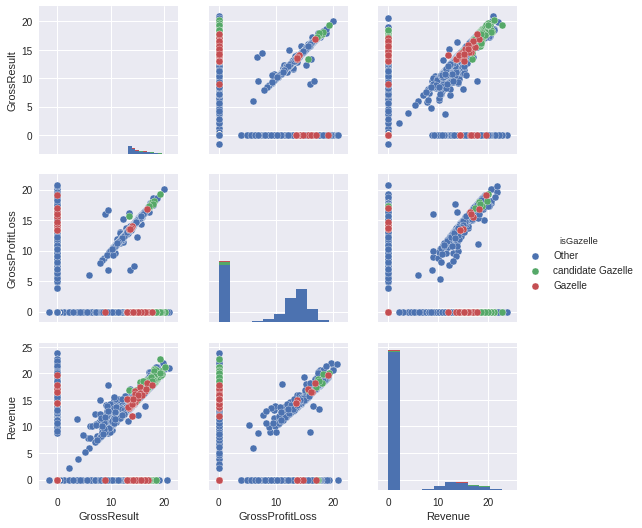

In [9]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2013).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.savefig(picture_Path+"/EntireIktBranche2013.png")
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


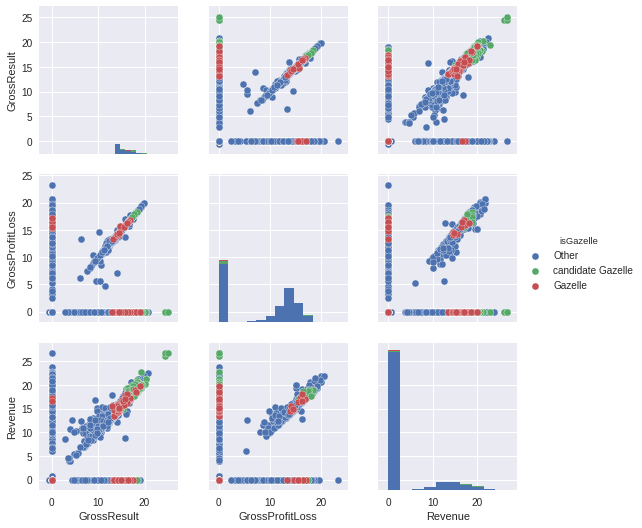

In [10]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2014).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.savefig(picture_Path+"/EntireIktBranche2014.png")
plt.show()

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


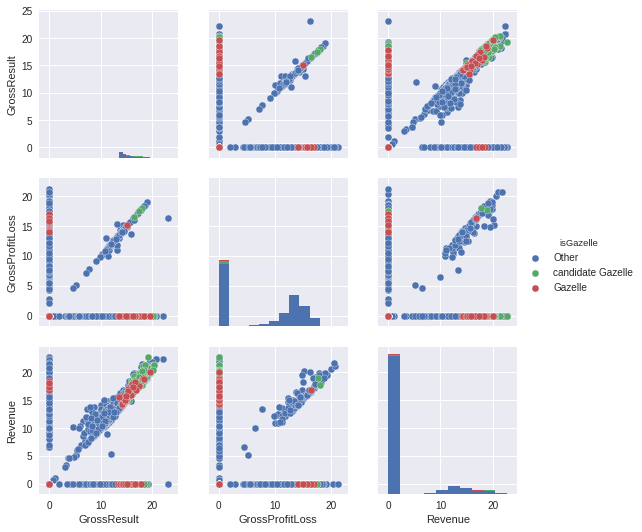

In [11]:
sb.pairplot(totalIktUnionDf.filter(F.col("Year")==2015).drop("cvr").drop("Year").drop("branchetekst").drop("Standardgruppering_19").toPandas(),hue="isGazelle")
plt.savefig(picture_Path+"/EntireIktBranche2015.png")
plt.show()

In [12]:
#Show a subsample brancher for revenue and Gross Result 
pandasNotGazeller = (notIktGazelleDf
                     .select("cvr","branchekode","Branchenavn","GrossResult","Revenue",F.year(F.col("End_Instant")).alias("Year"))
                     #.filter((F.col("branchekode") == 620100) | (F.col("branchekode") == 620200) )
                     .toPandas()
                    )

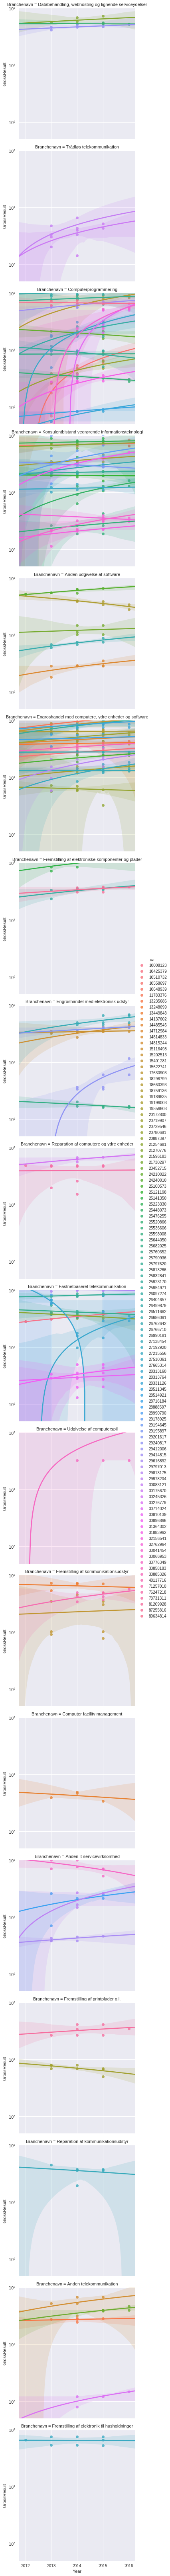

In [13]:


ax = sb.lmplot("Year","GrossResult",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=True,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax.set(yscale="log")
ax.set(ylim=[500000,100000000])
plt.savefig(picture_Path+"/GrossResultPrYear.png")
plt.show()

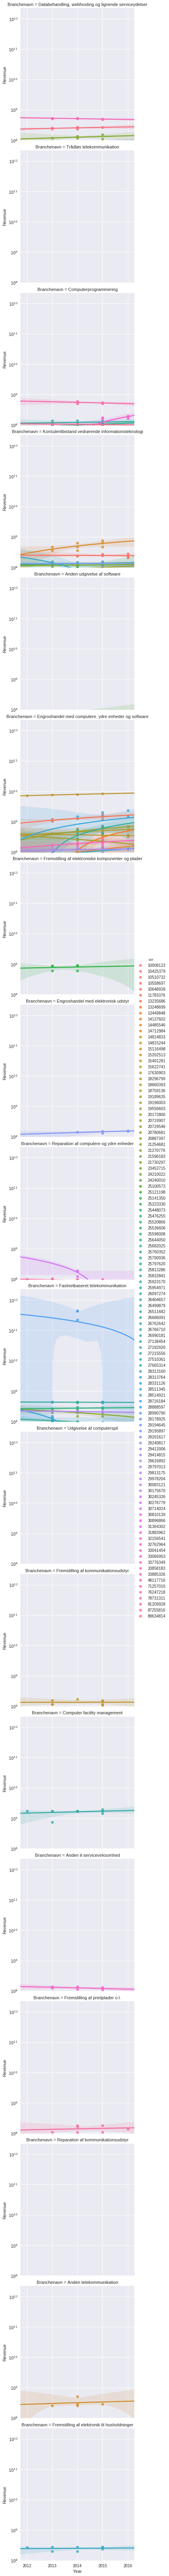

In [14]:
ax2 = sb.lmplot("Year","Revenue",pandasNotGazeller,fit_reg=True,hue="cvr",sharex=True,logx=False,legend=True,size=5,row="Branchenavn")
#ax.map(plt.plot,"Year","GrossResult")
ax2.set(yscale="log")
ax2.set(ylim=[500000,100000000])
plt.savefig(picture_Path+"/RevenuePrYear.png")
plt.show()

In [15]:
#Build the pipeline here!


vecAss = VectorAssembler(inputCols=["Year"],outputCol="features")
lg = LinearRegression(labelCol="GrossResult",regParam=0.1,elasticNetParam=0.1)
pipeGro = Pipeline(stages=[vecAss,lg])

lg2 = LinearRegression(labelCol="Revenue",regParam=0.1,elasticNetParam=0.1)
pipeRev = Pipeline(stages=[vecAss,lg2])

In [16]:
paramGrid = (ParamGridBuilder()
             .baseOn({lg.maxIter:10})
             
             .baseOn({lg.featuresCol:vecAss.getOutputCol()})     
             .addGrid(lg.elasticNetParam, [0.5])
             .addGrid(lg.regParam,[0.1])
             .build())


crossvalGro = CrossValidator(estimator=pipeGro,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=2)  # use 3+ folds in practice

In [158]:
def executeLinearRegressionsYearVar(df,targetCol,crossval,maxYear=6):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    #Extract unqiue cvr-numbers
    uniqueTargetValues = (df
                          .select(targetCol)
                          .distinct()
                          .rdd
                          .map(lambda x: x[0])
                          .collect()
                         )
    
    modelsPrCvr = {} # add all models with cvr numbers in this one.
    
    #yearDf = sqlContext.range(1,maxYear).withColumnRenamed("id","Year").cache()
    
    #Run through all cvr-numbers
    for company in uniqueTargetValues:
        try:
            tempDf = df.filter(F.col(targetCol) == company)
            #tempDf.show(5)
            if tempDf.count() < 3:
                print("this should not happen: "+str(tempDf.count()))
            else:
                model = crossval.fit(tempDf) # create model             
                
                modelsPrCvr[company] = model
        except:
            tempDf.show()
            #tempDf.printSchema()
            #break

    
    return modelsPrCvr
    
def evaluateAllModels(df,colName,dict,evaluator):
    """
        this method should do linear regression for 
        each of the companies or another column that we can chose. 
    """
    
    
    yearDf = sqlContext.range(2012,2017).withColumnRenamed("id","Year").cache()
    dictDf = {}
    if colName == "cvr":
        for idx,val in dict.items():

            tempDf = df.filter(F.col(colName) == idx)
            prediction = val.transform(tempDf)

            dictDf[idx] = (evaluator.evaluate(prediction),val.transform(yearDf),hasIncreasedtoDouble(val.transform(yearDf)))
    else:
        cvrs = df.select("cvr",colName).distinct().rdd.map(lambda x: (x[0],x[1]))
        print(cvrs.take(5))
        predictions = {}
        
        for idx,val in dict.items():
            predictions[idx] = val.transform(yearDf).cache()
        
        for (idx,val) in cvrs.collect():
            
            tempDf = df.filter(F.col("cvr") == idx)
            model = dict[val]
            prediction = model.transform(tempDf)

            dictDf[idx] = (evaluator.evaluate(prediction),model.transform(yearDf),hasIncreasedtoDouble(predictions[val]))

            
    return dictDf




def hasIncreasedtoDouble(prediction,startYear=2012,endYear=2016):
    """
        returns try or false to wheter if a company has more than doubled its size in revenue or grossResult
    """
    
    zeroVal = prediction.filter(F.col("Year") == startYear).collect()[0]["prediction"]
    endVal = prediction.filter(F.col("Year") == endYear).collect()[0]["prediction"]
    if endVal >= (zeroVal*2):
        return True
    else: 
        return False
    

In [152]:
print("entire IKT: " + str(iktBrancheDf.count()))
print("gazels in IKT: " + str(iktGazelleDf.count()))
print("Non-gazels in IKT: " + str(notIktGazelleDf.count()))

entire IKT: 41410
gazels in IKT: 364
Non-gazels in IKT: 672


In [56]:
notIktGazelleDf.show()

+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|     cvr|branchekode|unitRef|End_Instant|GrossResult|GrossProfitLoss|    Revenue|        branchetekst|         Branchenavn|Standardgruppering_19|         IKT-områder|LaggedGrossResult|FirstRevenue|FirstGrossResult|Year|
+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|25476255|     631100|    DKK| 2014-06-30| 5.251484E7|    5.2514844E7|7.1780952E7|Informationstjene...|Databehandling, w...| Information og ko...|IKT-service, kons...|       5.251484E7|        true|            true| 0.0|
|25476255|     631100|    DKK| 2015-06-30|   5.5079E7|            0.0|7.7901472E7|Informationstjene...|Databehandlin

In [57]:
# Run cross-validation, and choose the best set of parameters.
allModelsRev = executeLinearRegressionsYearVar(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"cvr",pipeRev)
allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"cvr",pipeGro)

In [62]:
regressionEvaluatorGro = RegressionEvaluator(predictionCol="prediction",labelCol="GrossResult",metricName="rmse")
regressionEvaluatorRev = RegressionEvaluator(predictionCol="prediction",labelCol="Revenue",metricName="rmse")


In [136]:
modelsDictRev = evaluateAllModels(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"cvr",allModelsRev,regressionEvaluatorRev)
modelsDictGro = evaluateAllModels(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"cvr",allModelsGro,regressionEvaluatorGro)

In [64]:
filtered_Rev = {k:v for (k,v) in modelsDictRev.items() if v[2] == True}
filtered_Gross = {k:v for (k,v) in modelsDictGro.items() if v[2] == True}

In [129]:
#predicted Gazeller for IKT GrossResult
import csv


fieldNames = ["cvr","root-mean-squared","isGazelle",2012,2013,2014,2015,2016]

#map(lambda x:{fieldNames[0]:x[0],fieldNames[1]:val[1][0],fieldNames[2]:val[1][2],},filtered_Gross.items())


gazellePredictions = list(map(lambda val: {val[0]:dict(val[1][1].rdd.map(lambda x: (x["Year"],x["prediction"])).collect() )},filtered_Gross.items()))



gazelleGross = list(map(lambda val: {k:v for (k,v) in ([(fieldNames[0],val[0])
                                     ,(fieldNames[1],val[1][0])
                                     ,(fieldNames[2],val[1][2])]+val[1][1].rdd.map(lambda x:(x["Year"],x["prediction"])).collect())}
                        ,filtered_Gross.items()))

gazelleRev = list(filter(lambda x: x["root-mean-squared"] != 0,map(lambda val: {k:v for (k,v) in ([(fieldNames[0],val[0])
                                     ,(fieldNames[1],val[1][0])
                                     ,(fieldNames[2],val[1][2])]+val[1][1].rdd.map(lambda x:(x["Year"],x["prediction"])).collect())}
                        ,filtered_Rev.items())))
print(gazelleRev)
with open('/home/svanhmic/workspace/results/pictures/AlleGazellerCvrModel2016.csv', 'w') as csvfile:  
    spamwriter = csv.DictWriter(csvfile,fieldnames=fieldNames, delimiter="\t",quotechar=';', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writeheader()
    for val in gazelleGross+gazelleRev:
        spamwriter.writerow(val)
    

[{2016: 65089246.74897385, 'root-mean-squared': 6376065.997754495, 2012: 26987271.251026154, 'isGazelle': True, 'cvr': 26762642, 2013: 36512765.125514984, 2014: 46038259.0, 2015: 55563752.874485016}, {2016: 5225882.133868694, 'root-mean-squared': 857860.4027394229, 2012: -2612940.9236941338, 'isGazelle': True, 'cvr': 14712984, 2013: -653235.1593031883, 2014: 1306470.6050872803, 2015: 3266176.369477749}, {2016: 680534964.530426, 'root-mean-squared': 106168027.3828022, 2012: 274243700.694458, 'isGazelle': True, 'cvr': 20719907, 2013: 375816516.6534424, 2014: 477389332.61242676, 2015: 578962148.5714417}, {2016: 713242621.6243286, 'root-mean-squared': 106228636.03750727, 2012: 286910116.8257446, 'isGazelle': True, 'cvr': 14814833, 2013: 393493243.0253906, 2014: 500076369.2250366, 2015: 606659495.4246826}, {2016: 149684940.9265976, 'root-mean-squared': 18971550.166645456, 2012: 43606588.44673157, 'isGazelle': True, 'cvr': 14485546, 2013: 70126176.56669617, 2014: 96645764.6866684, 2015: 1231

In [134]:
allModelsForBrancheRev

{'261100': PipelineModel_4f0d8142d496587e7b23,
 '261200': PipelineModel_4bf3a0d28c7909e30737,
 '263000': PipelineModel_4054bfc9c85617c21757,
 '264000': PipelineModel_49ff826779b2fed05404,
 '465100': PipelineModel_42afa8f737cddb207f3e,
 '465210': PipelineModel_4dabb7287714ca68b665,
 '582100': PipelineModel_4beda66e90d256682ece,
 '582900': PipelineModel_4858bad1e47fe14331da,
 '611000': PipelineModel_430b972dac7c8c34be36,
 '612000': PipelineModel_4493aa294d98a57e21ba,
 '619000': PipelineModel_494382187cade35d0c15,
 '620100': PipelineModel_4033ac40c0394ae5da53,
 '620200': PipelineModel_4b8fa5c36e55c1ec17bf,
 '620300': PipelineModel_495c97745cb6aec30d98,
 '620900': PipelineModel_400cad97aebdc1d12d18,
 '631100': PipelineModel_4487b1892d820c946bbe,
 '951100': PipelineModel_47299b237b3f2a7af0ba,
 '951200': PipelineModel_432986e2c9c39272bb20}

In [ ]:
### regression pr branche? 

In [159]:
allModelsForBrancheRev = executeLinearRegressionsYearVar(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"branchekode",pipeRev)
allModelsForBrancheGro = executeLinearRegressionsYearVar(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"branchekode",pipeGro)
#allModelsGro = executeLinearRegressionsYearVar(notIktGazelleDf,"cvr",pipeGro)

In [160]:
modelsDictRevBrancher = evaluateAllModels(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"branchekode",allModelsForBrancheRev,regressionEvaluatorRev)
modelsDictGroBrancher = evaluateAllModels(notIktGazelleDf.withColumn("Year",F.year("End_Instant")),"branchekode",allModelsForBrancheGro,regressionEvaluatorGro)

[(25476255, '631100'), (29412006, '631100'), (30175670, '612000'), (25682025, '620100'), (31364302, '620200')]
[(25476255, '631100'), (29412006, '631100'), (30175670, '612000'), (25682025, '620100'), (31364302, '620200')]


In [161]:
modelsDictGroBrancher

{10008123: (2456896759.1352606,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 10425379: (22183429.911421757,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 10510732: (31882223.945525188,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 10558697: (33686233.860794775,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 10648939: (12391344.944811482,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 11783376: (38642515.08342868,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 13235686: (5929610.581509474,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 13248699: (20457653.316092946,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 13449848: (24830479.13265512,
  DataFrame[Year: bigint, features: vector, prediction: double],
  False),
 14137602: (416546743.0601517,
  DataFra

In [162]:
filtered_RevBrancher = {k:v for (k,v) in modelsDictRevBrancher.items() if v[2] == True}
filtered_GrossBrancher = {k:v for (k,v) in modelsDictGroBrancher.items() if v[2] == True}

In [163]:
notIktGazelleDf.show()

+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|     cvr|branchekode|unitRef|End_Instant|GrossResult|GrossProfitLoss|    Revenue|        branchetekst|         Branchenavn|Standardgruppering_19|         IKT-områder|LaggedGrossResult|FirstRevenue|FirstGrossResult|Year|
+--------+-----------+-------+-----------+-----------+---------------+-----------+--------------------+--------------------+---------------------+--------------------+-----------------+------------+----------------+----+
|25476255|     631100|    DKK| 2014-06-30| 5.251484E7|    5.2514844E7|7.1780952E7|Informationstjene...|Databehandling, w...| Information og ko...|IKT-service, kons...|       5.251484E7|        true|            true| 0.0|
|25476255|     631100|    DKK| 2015-06-30|   5.5079E7|            0.0|7.7901472E7|Informationstjene...|Databehandlin

In [164]:
gazelleBrancheGross = list(map(lambda val: {k:v for (k,v) in ([(fieldNames[0],val[0])
                                     ,(fieldNames[1],val[1][0])
                                     ,(fieldNames[2],val[1][2])]+val[1][1].rdd.map(lambda x:(x["Year"],x["prediction"])).collect())}
                        ,filtered_GrossBrancher.items()))

gazelleBrancheRev = list(filter(lambda x: x["root-mean-squared"] != 0,map(lambda val: {k:v for (k,v) in ([(fieldNames[0],val[0])
                                     ,(fieldNames[1],val[1][0])
                                     ,(fieldNames[2],val[1][2])]+val[1][1].rdd.map(lambda x:(x["Year"],x["prediction"])).collect())}
                        ,filtered_RevBrancher.items())))
print(gazelleBrancheGross)
with open('/home/svanhmic/workspace/results/pictures/AlleGazellerBrancheModel2016.csv', 'w') as csvfile:  
    spamwriter = csv.DictWriter(csvfile,fieldnames=fieldNames, delimiter="\t",quotechar=';', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writeheader()
    for val in gazelleBrancheGross+gazelleBrancheRev:
        spamwriter.writerow(val)

[{2016: 26224924.918067932, 'root-mean-squared': 12033070.158833195, 2012: 10397975.914952278, 'isGazelle': True, 'cvr': 20172800, 2013: 14354713.16573143, 2014: 18311450.416510582, 2015: 22268187.667289734}, {2016: 5474677.281929016, 'root-mean-squared': 1499873.0794355047, 2012: 2564935.598392248, 'isGazelle': True, 'cvr': 30083121, 2013: 3292371.0192763805, 2014: 4019806.4401607513, 2015: 4747241.861044884}, {2016: 26224924.918067932, 'root-mean-squared': 14246902.200145395, 2012: 10397975.914952278, 'isGazelle': True, 'cvr': 81209928, 2013: 14354713.16573143, 2014: 18311450.416510582, 2015: 22268187.667289734}, {2016: 5474677.281929016, 'root-mean-squared': 1093319.1696867072, 2012: 2564935.598392248, 'isGazelle': True, 'cvr': 30175670, 2013: 3292371.0192763805, 2014: 4019806.4401607513, 2015: 4747241.861044884}, {2016: 105071999.9573822, 'root-mean-squared': 58773837.39386088, 2012: -3755999.829551697, 'isGazelle': True, 'cvr': 33858183, 2013: 23451000.1171875, 2014: 50658000.0639

In [178]:
debtNameCols = ["ShorttermDebtToBanks","LongtermMortgageDebt","ShorttermDebtToOtherCreditInstitutions","LongtermDebtToBanks","LongtermDebtToOtherCreditInstitutions","ShorttermMortgageDebt"]

In [176]:
import re

In [194]:

def containsColumns(value):
    debtNameCols = ["ShorttermDebtToBanks","LongtermMortgageDebt"
                    ,"ShorttermDebtToOtherCreditInstitutions","LongtermDebtToBanks"
                    ,"LongtermDebtToOtherCreditInstitutions","ShorttermMortgageDebt"]
    
    if value in debtNameCols:
        return True
    else:
        return False
    
containsColsUdf = F.udf(lambda x: containsColumns(x),BooleanType())    

In [165]:
debtCols = ["Name",F.col("EntityIdentifier").alias("cvr"),F.year("End_Instant").alias("Year"),"Value","Dimensions"]

In [211]:
debtDf = (sqlContext
          .read
          .parquet(regnskabParquetPath+"regnskaberDebt.parquet")
          .select(debtCols)
          #.select("*",F.explode("Dimensions").alias("stringDim"))
          #.withColumn("stringDim",F.regexp_extract("stringDim",r"(Consolidated)",0))
          #.filter(F.col("stringDim") == "")
          #.drop("stringDim")
          #.drop("Dimensions")
          #.dropDuplicates()
          #.withColumn("Value",F.log1p(F.regexp_replace("Value","[,]","").cast("double")))
          #.withColumn("Name",F.regexp_replace("Name",r'\w+:',''))
          #.groupBy("cvr","Year")
          #.pivot("Name")
          #.max("Value")
         )
#debtDf.show(truncate=False)
#debtCol = list(map(lambda x: x[0],debtDf.collect()))
#debtDf.select(F.col("Name")).distinct().show()
#whos in it?
print(debtDf.columns)


def containsConsolidated(arr):
    
    for a in arr:
        pattern = re.search(pattern=r":Consol",string=a,flags=re.IGNORECASE)
        if pattern != "":
            return True
    return False

consolidatedUdf = F.udf(lambda x: containsConsolidated(x),BooleanType())

manipulatedDebtDf = (debtDf
                     .select("cvr",F.regexp_replace("Name","\w+:|\w+-","").alias("Name"),"Year",consolidatedUdf("Dimensions").alias("containsDim"),"Value")
                     .filter(F.col("containsDim") == False)
                     .filter(containsColsUdf(F.col("Name")) )
                     .withColumn("Value",F.regexp_replace(F.col("Value"),"\,","").cast("double"))
                     .drop(F.col("containsDim"))
                     .groupBy("cvr","Year")
                     .pivot("Name",debtNameCols)
                     .max("Value")
                     .na.fill(0.0)
                     .select(["cvr","Year"]+[F.log1p(i).alias(i) for i in debtNameCols])
                    )
manipulatedDebtDf.show()

['Name', 'cvr', 'Year', 'Value', 'Dimensions']
+--------+----+--------------------+--------------------+--------------------------------------+-------------------+-------------------------------------+---------------------+
|     cvr|Year|ShorttermDebtToBanks|LongtermMortgageDebt|ShorttermDebtToOtherCreditInstitutions|LongtermDebtToBanks|LongtermDebtToOtherCreditInstitutions|ShorttermMortgageDebt|
+--------+----+--------------------+--------------------+--------------------------------------+-------------------+-------------------------------------+---------------------+
|34734534|2016|                 0.0|                 0.0|                                   0.0|                0.0|                                  0.0|                  0.0|
|26398363|2015|                 0.0|                 0.0|                     11.93041136630502|                0.0|                                  0.0|                  0.0|
|20861770|2015|   16.76121841597388|                 0.0|           

In [212]:
debtAndIktDf = totalIktUnionDf.join(manipulatedDebtDf,(["cvr","Year"]),"left").na.fill(0.0)
debtIktcols = ["year","GrossResult","GrossProfitLoss","Revenue","branchetekst","isGazelle"]+debtNameCols

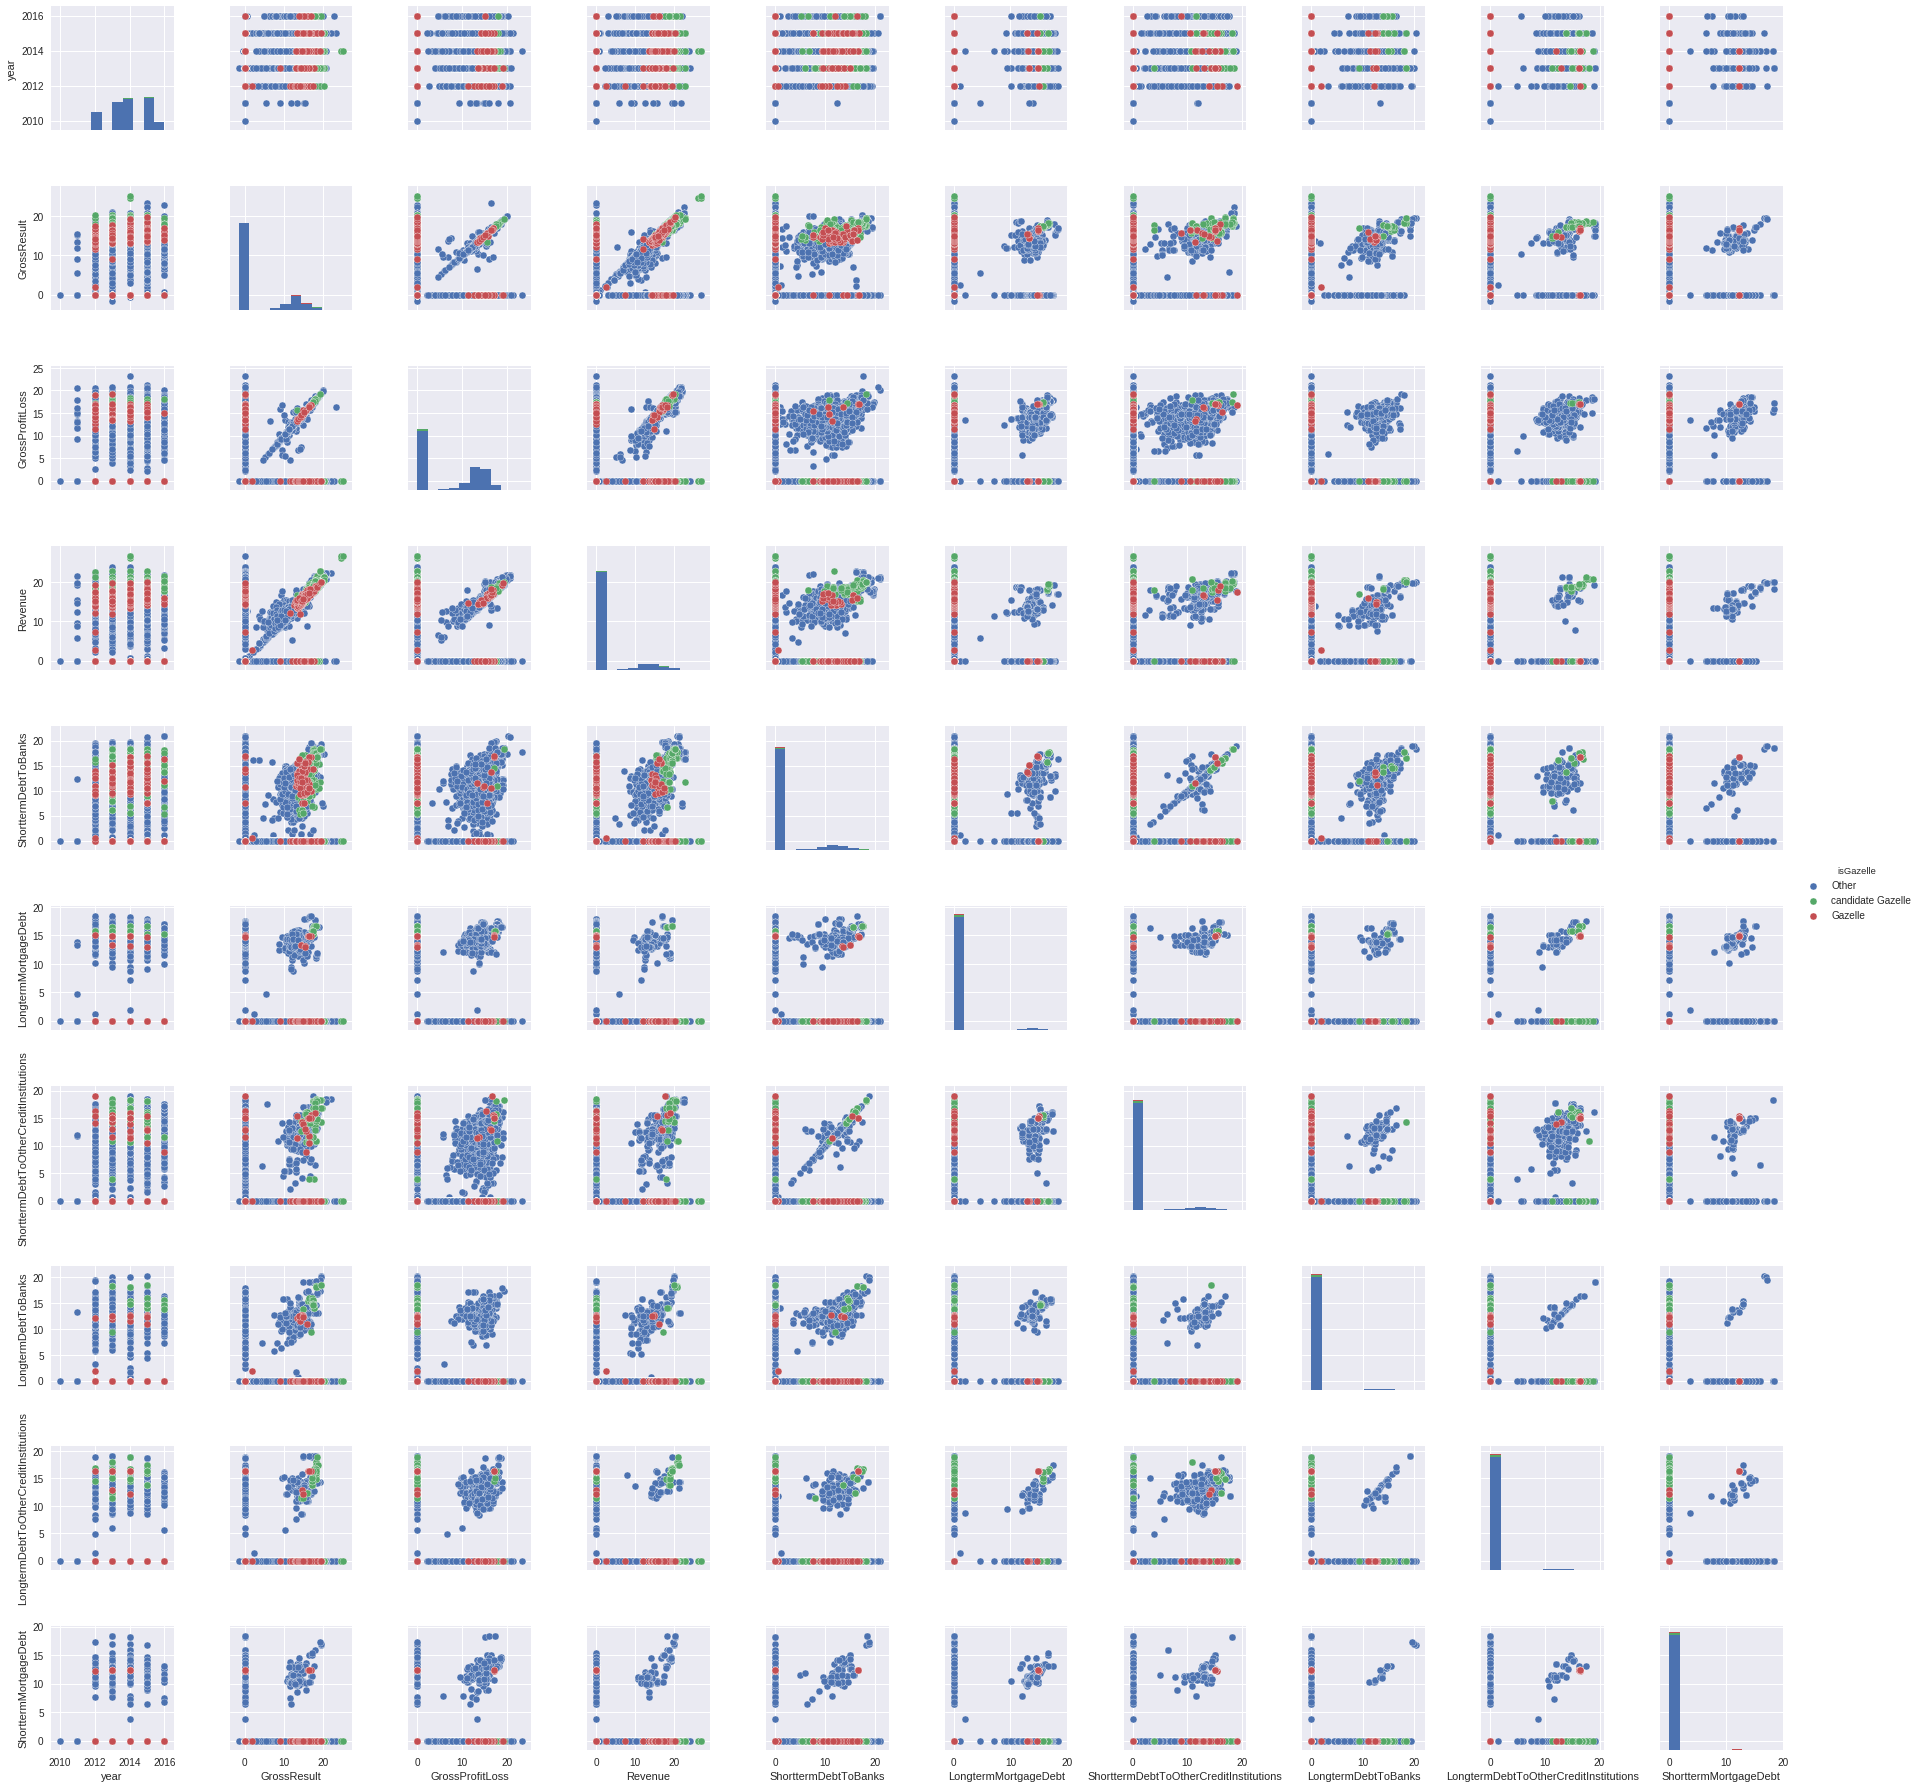

In [213]:
sb.pairplot(data=debtAndIktDf.select(debtIktcols).toPandas(),hue="isGazelle")
plt.savefig(picture_Path+"/GrossReveuneAndDebt.png")
plt.show()
